In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

import pandas as pd
import numpy as np
#Vacation days: 06-11-2018 through 06-18-2018
import matplotlib.pyplot as plt
import matplotlib.dates as dates

import re

In [3]:
#use SQLAlchemy create_engine to connect to the sqlite database
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [4]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'stations']

In [5]:
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [6]:
columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'])

id
station
date
prcp
tobs


In [7]:
#reflect tables into classes and save a reference called Station and Measurement
Station = Base.classes.stations
Measurement = Base.classes.measurements

In [8]:
# create a session
session = Session(engine)

In [9]:
#Precipitation Analysis
#Dependencies
import datetime as dt 
from datetime import date

In [10]:
today=date.today()
last_year=date.today()-dt.timedelta(365)

print(today)
print(last_year)

2018-05-01
2017-05-01


In [11]:
data = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=last_year).all()

In [12]:
#put the pulled data into a dataframe
precip_analys = pd.DataFrame(data)

#rename prcp to Precipitation and set the date to the index
precip_analys=precip_analys.rename(columns={"prcp":"precipitation"})
precip_analys= precip_analys.groupby(by='date').mean()

precip_analys.head()

,precipitation
date,
2017-05-01,0.135000
2017-05-02,0.008333
2017-05-03,0.006000
2017-05-04,0.016000
2017-05-05,0.063333


In [13]:
precip_analys.precipitation.count()

115

In [14]:
precip_label = []

ind = 0
for item,i in enumerate(precip_analys["precipitation"]):
    if ind % 10 == 0:
        precip_label.append(precip_analys.index[ind])
    ind = ind + 1

precip_label

['2017-05-01',
 '2017-05-11',
 '2017-05-21',
 '2017-05-31',
 '2017-06-10',
 '2017-06-20',
 '2017-06-30',
 '2017-07-10',
 '2017-07-20',
 '2017-07-30',
 '2017-08-09',
 '2017-08-19']

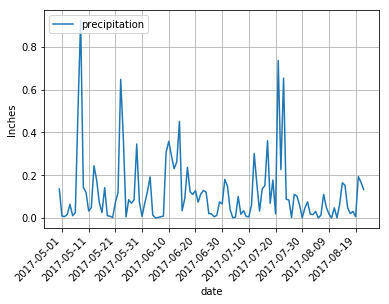

In [15]:
precip_analys.plot(x_compat=True)
plt.tight_layout

plt.legend(loc=2)
plt.grid(True)
plt.ylabel("Inches")

plt.xticks(np.arange(1,117,step=10),precip_label,rotation=45,ha='right')
plt.show()

In [16]:
#print the summary statistics for the precipitation data.
summary = precip_analys.describe()

print(summary)
print(summary.iloc[0,0])

       precipitation
count     115.000000
mean        0.119059
std         0.158364
min         0.000000
25%         0.017083
50%         0.070000
75%         0.145667
max         0.926000
115.0


In [17]:
#Station Analysis
columns = inspector.get_columns('stations')
for c in columns:
    print(c['name'])

id
station
name
latitude
longitude
elevation


In [18]:
#Design a query to calculate the total number of stations
num_stations = session.query(Station.id).count()

num_stations

9

In [19]:
#Design a query to find the most active stations
active_stations = session.query(Measurement.station,
                                func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

#List the stations and obsevation counts in descending order
print(active_stations)

[('USC00519281', 2772), ('USC00513117', 2696), ('USC00519397', 2685), ('USC00519523', 2572), ('USC00516128', 2484), ('USC00514830', 1937), ('USC00511918', 1932), ('USC00517948', 683), ('USC00518838', 342)]


In [21]:
#Which station has the highest number of observations?
print(active_stations[0][0] + " is the most active station with " +
      str(active_stations[0][1]) + " obsevations.")

USC00519281 is the most active station with 2772 obsevations.


In [119]:
#Design a query to retrieve the last 12 months of temperature observation data (tobs)

active_tobs = session.query(Measurement.station,Measurement.date,Measurement.tobs).filter(Measurement.date>=last_year,Measurement.station==active_stations[0][0]).order_by(Measurement.tobs).all()

In [120]:
#plot the results as a histogram with bins=12

df_tobs = pd.DataFrame(data=active_tobs,columns=["station_id","date","tobs"])

df_tobs.head()

,station_id,date,tobs
0,USC00519281,2017-05-01,65.0
1,USC00519281,2017-05-09,67.0
2,USC00519281,2017-05-19,68.0
3,USC00519281,2017-05-18,69.0
4,USC00519281,2017-07-10,69.0


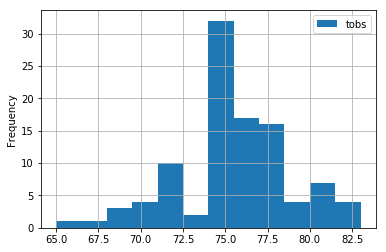

In [121]:
plt.hist(df_tobs.tobs,bins=12)

plt.legend(["tobs"])
plt.ylabel("Frequency")
plt.grid()

plt.show()

In [110]:
#Temperature Analysis
def calc_temps(start_date,end_date):
    try: 
        #verify start date and end date are in the right format
        s_date = dt.datetime.strptime(start_date,"%y-%m-%d")
        e_date = dt.datetime.strptime(end_date,"%y-%m-%d")
        
        #find matching dates from the previous year
        p_s_date = s_date-dt.timedelta(365)
        p_e_date = e_date-dt.timedelta(365)
        
        #query measurements to see what the weather was like the previous year
        print("Searching for weather data from " + str(p_s_date) + " to " + str(p_e_date))
        
        weather_data = session.query(Measurement.date,func.avg(Measurement.tobs)).filter(Measurement.date>=p_s_date,Measurement.date<=p_e_date).group_by(Measurement.date).all()
        
        df_weather = pd.DataFrame(data=weather_data,columns=["date","temp"])
        min_temp = df_weather["temp"].min()
        max_temp = df_weather["temp"].max()
        mean_temp = df_weather["temp"].mean()
        
        print("min_temp, max_temp, and mean_temp are returned")
        return min_temp, max_temp, mean_temp
        
    except:
        print("input dates are not in correct format. Dates should be formated as %y-%d-%y")

In [111]:
date1 = input("Please input a start date (%y-%m-%d): ")
date2 = input("Please input an end date (%y-%m-%d): ")

Please input a start date (%y-%m-%d): 18-04-01
Please input an end date (%y-%m-%d): 18-06-01


In [112]:
temps = calc_temps(date1,date2)

min_temp = temps[0]
max_temp = temps[1]
mean_temp = temps[2]
print(temps)

Searching for weather data from 2017-04-01 00:00:00 to 2017-06-01 00:00:00
min_temp, max_temp, and mean_temp are returned
(61.5, 78.16666666666667, 74.35538641686183)


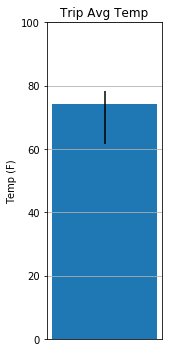

In [118]:
#plot the min, avg, and max temperatures

#calculate error bars
y_err1 = mean_temp - min_temp
y_err2 = max_temp - mean_temp

#plot bar chart
fig, ax = plt.subplots(figsize=(2.5,5))
bar = ax.bar("",height=mean_temp,yerr=[[y_err1],[y_err2]])

plt.ylim(0,100)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
fig.tight_layout()

plt.grid()
plt.show()